In [52]:
import multiprocessing as mp

# https://github.com/matplotlib/matplotlib/issues/15410#issuecomment-625027757
mp.set_start_method('forkserver')

In [81]:
%matplotlib inline
import warnings
from datetime import datetime
from functools import reduce

import matplotlib.pyplot as plt
import pandas as pd

from vortexasdk import CargoTimeSeries, Geographies, Products
from vortexasdk.utils import convert_to_list

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})

In [82]:
START_DATE = datetime(2019, 6, 10)
END_DATE = datetime(2020, 6, 10)
UNIT = 'b'

# Define helper functions

In [83]:
def get_product_id_exact(product_name):
    if product_name is None:
        return None
    
    products = [p.id for p in Products().search(product_name).to_list() if p.name==product_name]    
    assert len(products) == 1
    return products[0]

def get_geography_id_exact(geog_name):
    if geog_name is None:
        return None
    
    geogs = [g.id for g in Geographies().search(geog_name).to_list() if g.name==geog_name]    
    assert len(geogs) == 1
    return geogs[0]

In [84]:
def merge(data_frames):
    return reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="outer"
        ),
        data_frames,
    )

In [85]:
def plot_df(df, title=None, unit=UNIT):
    df.plot(title=title, grid=True)
    plt.xlabel('date')
    plt.ylabel('k' + unit)

In [86]:
def prepare_dataset(df_fs, product_names, destination_names, storage_names, filter_activity):

    # just keep key and value
    df_fs = df_fs[['key', 'value']]

    # use kilo unit not unit
    df_fs['value'] = df_fs['value'] / 1000


    # rename columns
    col_name = str((destination_names or " ")) + \
        " " + str((storage_names) or " ") + \
        " " + str((product_names) or " ") + \
        ": " + filter_activity

    df_fs = df_fs.rename(columns={'key': 'date', 'value': col_name})

    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)

    return df_fs.set_index('date')

In [87]:
def fetch_timeseries(filter_activity, product_names=None, destination_names=None, storage_names=None,
                    unit=UNIT, frequency='day', start_date=START_DATE, end_date=END_DATE):
    
    # Generate IDs
    product_ids = [get_product_id_exact(name) for name in convert_to_list(product_names)]
    destination_ids = [get_geography_id_exact(name) for name in convert_to_list(destination_names)]
    storage_ids = [get_geography_id_exact(name) for name in convert_to_list(storage_names)]
    
    
    # Load Data
    df = CargoTimeSeries().search(timeseries_frequency=frequency,
                                     timeseries_unit=unit,
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=product_ids,
                                     filter_destinations=destination_ids,
                                     filter_storage_locations=storage_ids,
                                     filter_activity=filter_activity,
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # Rename columns, set index etc
    return prepare_dataset(df, product_names, destination_names, storage_names, filter_activity)
    


# Define our commonly used constants

In [88]:
clean = "Clean Petroleum Products"
naphtha = "Naphtha"
diesel_gasoil = "Diesel/Gasoil"
gasoline_blending_components = "Gasoline/Blending Components"
jet_kero = "Jet/Kero"

# Analysis Start

### Load all global clean floating storage cargos

In [89]:
clean_fs = fetch_timeseries("storing_state", clean)
clean_fs.head()

,Clean Petroleum Products: storing_state
date,
2019-06-10,28275.824
2019-06-11,28572.234
2019-06-12,27440.642
2019-06-13,27306.334
2019-06-14,28177.139


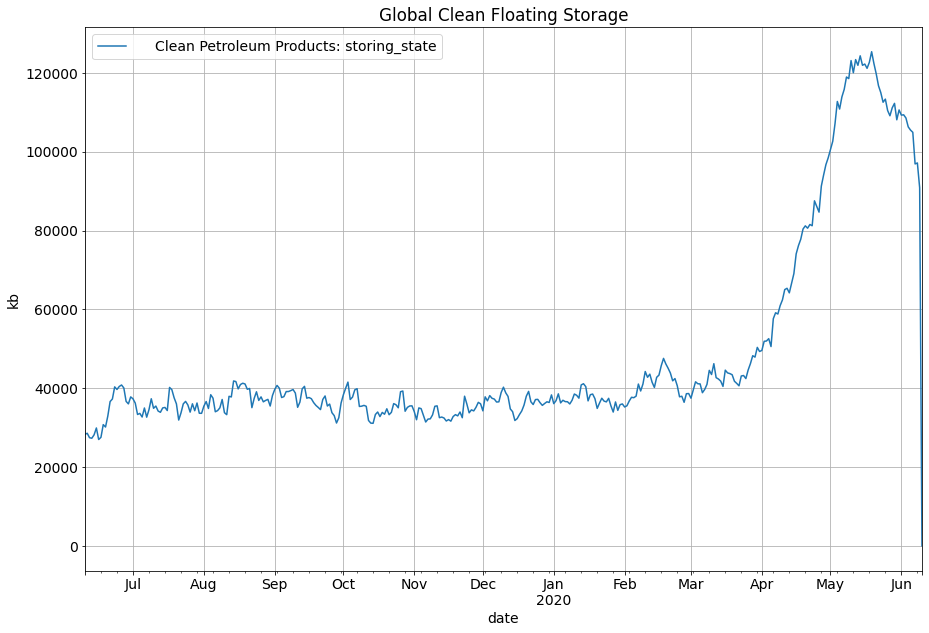

In [90]:
plot_df(clean_fs, "Global Clean Floating Storage")

### Let's look at the product split of these global floating storage cargos

In [91]:
data_frames = [
    fetch_timeseries("storing_state", gasoline_blending_components),
    fetch_timeseries("storing_state", diesel_gasoil),
    fetch_timeseries("storing_state", naphtha),
    fetch_timeseries("storing_state", jet_kero)
]

df_merged = merge(data_frames)
df_merged.head()

,Gasoline/Blending Components: storing_state,Diesel/Gasoil: storing_state,Naphtha: storing_state,Jet/Kero: storing_state
date,,,,
2019-06-10,7184.033,11248.500,1519.893,896.613
2019-06-11,7056.326,10627.893,1442.768,673.131
2019-06-12,7061.802,10525.544,766.018,673.131
2019-06-13,6708.143,9936.323,766.018,767.094
2019-06-14,6812.918,10646.097,766.018,854.251


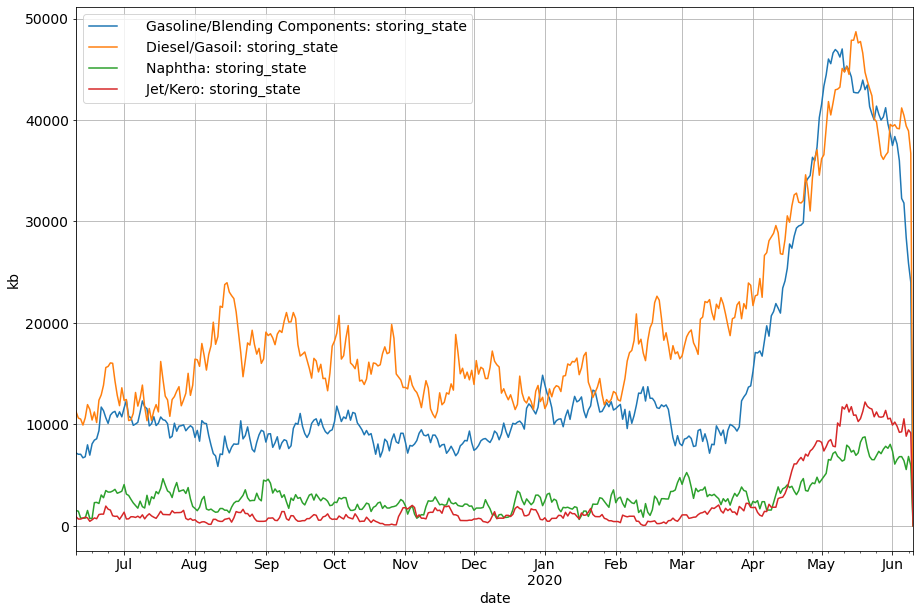

In [92]:
plot_df(df_merged)

### Asia-only floating storage

In [93]:
dfs_asia = [
    fetch_timeseries("storing_state", storage_names="Asia", product_names=gasoline_blending_components),
    fetch_timeseries("storing_state", storage_names="Asia", product_names=diesel_gasoil),
    fetch_timeseries("storing_state", storage_names="Asia", product_names=naphtha),
    fetch_timeseries("storing_state", storage_names="Asia", product_names=jet_kero)
]

df_asia = merge(dfs_asia)
df_asia.head()

,Asia Gasoline/Blending Components: storing_state,Asia Diesel/Gasoil: storing_state,Asia Naphtha: storing_state,Asia Jet/Kero: storing_state
date,,,,
2019-06-10,393.260,4422.283,555.15,462.041
2019-06-11,429.093,4090.497,555.15,311.980
2019-06-12,330.501,3648.004,0.00,311.980
2019-06-13,545.668,3629.035,0.00,0.000
2019-06-14,545.668,3503.981,0.00,0.000


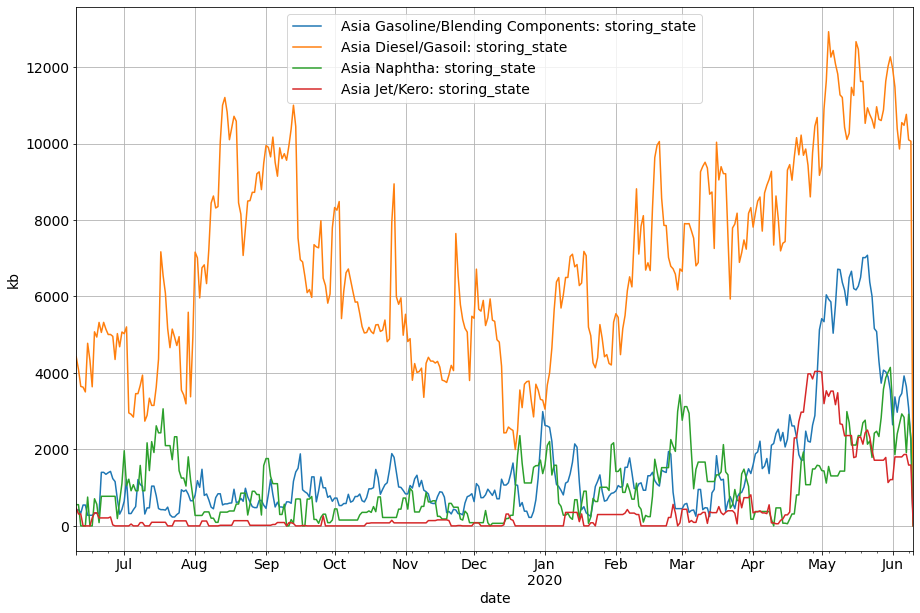

In [94]:
plot_df(df_asia)

###  See how Diesel/Gasoil storage levels are split across Asian geographies

In [95]:
dfs_diesel_gasoil_countries = [
    fetch_timeseries("storing_state", product_names=diesel_gasoil, storage_names="South Korea"),
    fetch_timeseries("storing_state", product_names=diesel_gasoil, storage_names="India"),
    fetch_timeseries("storing_state", product_names=diesel_gasoil, storage_names="China"),
    fetch_timeseries("storing_state", product_names=diesel_gasoil, storage_names=["Singapore", "Malaysia", "Indonesia"])
]

df_diesel_gasoil_countries = merge(dfs_diesel_gasoil_countries)
df_diesel_gasoil_countries.head()

,South Korea Diesel/Gasoil: storing_state,India Diesel/Gasoil: storing_state,China Diesel/Gasoil: storing_state,"['Singapore', 'Malaysia', 'Indonesia'] Diesel/Gasoil: storing_state"
date,,,,
2019-06-10,56.23,262.668,2092.033,1300.501
2019-06-11,0.00,10.988,2044.634,1300.501
2019-06-12,0.00,10.988,2044.634,1155.295
2019-06-13,0.00,10.988,2016.500,941.291
2019-06-14,0.00,10.988,1843.022,952.342


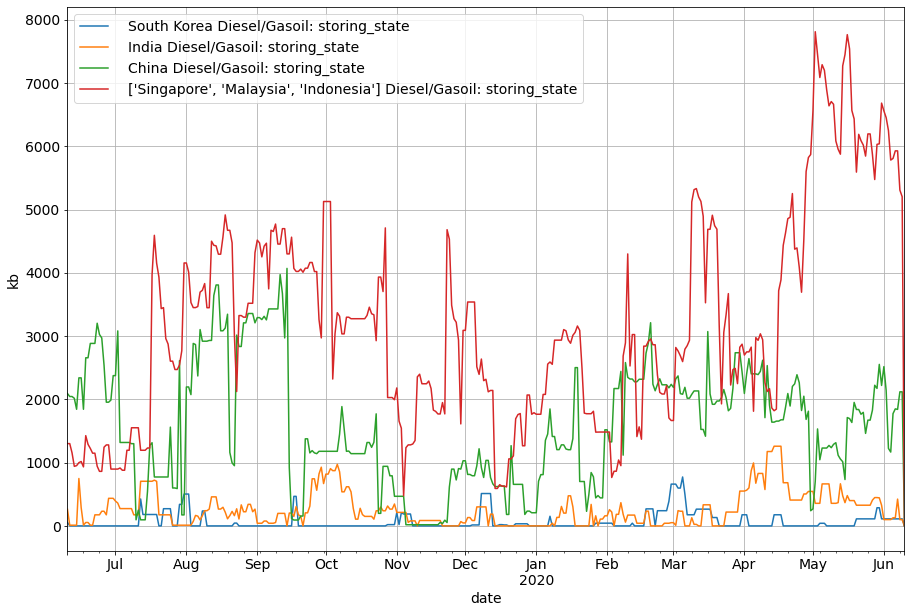

In [96]:
plot_df(df_diesel_gasoil_countries)

### Diesel/Gasoil Asian imports

In [97]:
end_date = datetime(2020, 5, 31)

In [98]:
dfs_imports = [
    fetch_timeseries("unloading_state", diesel_gasoil, unit='bpd', frequency='month', end_date=end_date, destination_names="Australia"),
    fetch_timeseries("unloading_state", diesel_gasoil, unit='bpd', frequency='month', end_date=end_date, destination_names="Indonesia"),
    fetch_timeseries("unloading_state", diesel_gasoil, unit='bpd', frequency='month', end_date=end_date, destination_names="Philippines"),
    fetch_timeseries("unloading_state", diesel_gasoil, unit='bpd', frequency='month', end_date=end_date, destination_names="Vietnam")
]

df_imports = merge(dfs_imports)

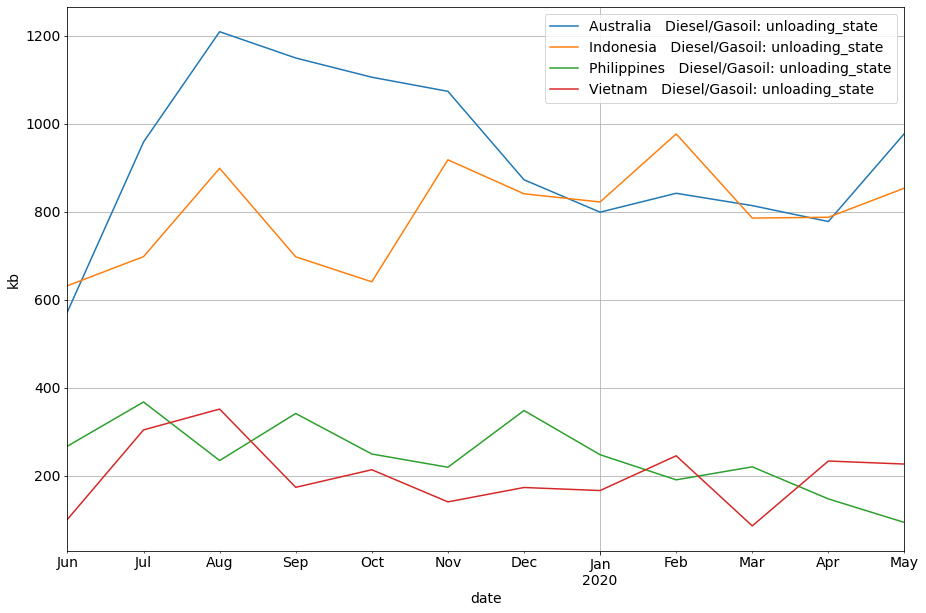

In [99]:
plot_df(df_imports)